<a href="https://colab.research.google.com/github/AhamadAli30/Knee-Osteoarthritis/blob/main/Coronal_detection_ENET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Preprocessing


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os

# Set the path to your dataset
dataset_path = "/content/drive/MyDrive/coronal_mask"

# Define the image size
IMG_HEIGHT = 256
IMG_WIDTH = 256

"""# Define the lower and upper bounds for the articular cartilage intensity
values. These values can be adjusted based on the properties of your
specific images. (105,500)"""
LOWER_BOUND = 105
UPPER_BOUND = 500

# Function for preprocessing the images
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0 # Normalize pixel values
    img = np.uint8(img * 255) # Convert image to 8-bit unsigned integer format
    img = np.expand_dims(img, axis=-1)
    return img

# Create a list of image paths and their corresponding labels
image_paths = []
labels = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

# Preprocess the images and store them in a list
preprocessed_images = []

for image_path in image_paths:
    preprocessed_image = preprocess_image(image_path)
    preprocessed_images.append(preprocessed_image)

# Convert the labels to numerical values
label_dict = {"Mild": 0,"Moderate": 1, "Normal": 2, "Severe": 3}
numerical_labels = [label_dict[label] for label in labels]

# Convert the preprocessed images and numerical labels to numpy arrays
X = np.array(preprocessed_images)
y = np.array(numerical_labels)


# Create a new list to store the segmented images
segmented_images = []

# Loop through each image and perform segmentation
for i in range(len(X)):
    img = X[i]
    # Apply a threshold to isolate the articular cartilage region
    _, thresh = cv2.threshold(img, LOWER_BOUND, UPPER_BOUND, cv2.THRESH_BINARY)


    #Apply morphological operations to remove noise and fill gaps in the articular cartilage region

    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Apply a mask to retain only the articular cartilage region
    masked_img = np.zeros_like(img)
    masked_img[closing == 255] = img[closing == 255]

    # Create a binary mask
    mask = np.zeros_like(masked_img)
    mask[masked_img > 0] = 1

    # Apply the mask to the image
    masked_img = masked_img * mask

    # Add the segmented image to the list
    segmented_images.append(masked_img)

# Convert the list of segmented images to a numpy array
X = np.array(segmented_images)

#print(labels[11])

print(X.shape)

(258, 256, 256, 1)


E-Net Model

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)
print(X_train.shape)

(180, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.models import Model

def initial_block(inputs):
    conv = Conv2D(13, (3, 3), strides=(2, 2), padding='same')(inputs)
    conv = BatchNormalization()(conv)
    conv = tf.keras.layers.PReLU()(conv)
    return conv

def bottleneck(inputs, output_size, internal_scale=4, dropout_prob=0.1):
    reduced = Conv2D(output_size // internal_scale, (1, 1))(inputs)
    reduced = BatchNormalization()(reduced)
    reduced = tf.keras.layers.PReLU()(reduced)

    conv = Conv2D(output_size // internal_scale, (3, 3), padding='same')(inputs)
    conv = BatchNormalization()(conv)
    conv = tf.keras.layers.PReLU()(conv)

    conv = Conv2D(output_size, (1, 1))(conv)
    conv = BatchNormalization()(conv)
    conv = tf.keras.layers.PReLU()(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    return concatenate([reduced, conv], axis=-1)

def build_enet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    initial = initial_block(inputs)

    down1 = bottleneck(initial, 64)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

    down2 = bottleneck(down1_pool, 128)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

    down3 = bottleneck(down2_pool, 256)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

    down4 = bottleneck(down3_pool, 512)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)

    bottleneck_center = bottleneck(down4_pool, 1024)

    up4 = UpSampling2D((2, 2))(bottleneck_center)
    up4 = bottleneck(up4, 512)

    up3 = UpSampling2D((2, 2))(up4)
    up3 = bottleneck(up3, 256)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = bottleneck(up2, 128)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = bottleneck(up1, 64)

    flat=tf.keras.layers.Flatten()(up1)
    #outputs = Conv2D(num_classes, (1, 1), activation='softmax')(up1)

    outputs = tf.keras.layers.Dense(4, activation='sigmoid')(flat)

    model = Model(inputs, outputs, name='ENet')
    return model

# Instantiate the ENet model
input_shape = (256, 256, 1)  # Adjust to your input shape
num_classes = 4  # Number of segmentation classes
model = build_enet(input_shape, num_classes)

# Print the model summary
model.summary()
print(X_train.shape)

Model: "ENet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 128, 128, 13  130         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 128, 13  52         ['conv2d_28[0][0]']              
 ormalization)                  )                                                              

In [ ]:
from keras.optimizers import SGD
#from tensorflow.keras.optimizers import Adam
custom_optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=custom_optimizer, loss="mean_squared_error", metrics=["accuracy"])

In [ ]:
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=25, batch_size=8, validation_data=(X_val, y_val))

Epoch 1/25
23/23 [==============================] - 8s 158ms/step - loss: 0.1000 - accuracy: 0.7222 - val_loss: 0.2227 - val_accuracy: 0.3148
Epoch 2/25
23/23 [==============================] - 3s 126ms/step - loss: 0.1502 - accuracy: 0.6389 - val_loss: 0.2258 - val_accuracy: 0.2407
Epoch 3/25
23/23 [==============================] - 3s 124ms/step - loss: 0.1622 - accuracy: 0.6000 - val_loss: 0.2038 - val_accuracy: 0.4630
Epoch 4/25
23/23 [==============================] - 3s 120ms/step - loss: 0.1505 - accuracy: 0.5778 - val_loss: 0.2077 - val_accuracy: 0.4444
Epoch 5/25
23/23 [==============================] - 3s 120ms/step - loss: 0.1446 - accuracy: 0.5889 - val_loss: 0.2231 - val_accuracy: 0.3519
Epoch 6/25
23/23 [==============================] - 3s 125ms/step - loss: 0.1324 - accuracy: 0.6167 - val_loss: 0.2112 - val_accuracy: 0.2037
Epoch 7/25
23/23 [==============================] - 3s 123ms/step - loss: 0.1300 - accuracy: 0.6611 - val_loss: 0.2150 - val_accuracy: 0.3704
Epoch 

In [ ]:
loss1 = model.evaluate(X_train, y_train)
print('Test Loss:', loss1)

6/6 [==============================] - 1s 120ms/step - loss: 0.0732 - accuracy: 0.7778
Test Loss: [0.07318458706140518, 0.7777777910232544]


In [ ]:
loss2 = model.evaluate(X_test, y_test)
print('Test Loss:', loss2)

1/1 [==============================] - 0s 115ms/step - loss: 0.1883 - accuracy: 0.3750
Test Loss: [0.1882970780134201, 0.375]


In [ ]:
from keras.mixed_precision.loss_scale_optimizer import LossScaleOptimizerV3
LossScaleOptimizerV3 = model.evaluate(X_val, y_val)
print('Test Loss:', LossScaleOptimizerV3)

2/2 [==============================] - 0s 97ms/step - loss: 0.2233 - accuracy: 0.3889
Test Loss: [0.22330361604690552, 0.3888888955116272]


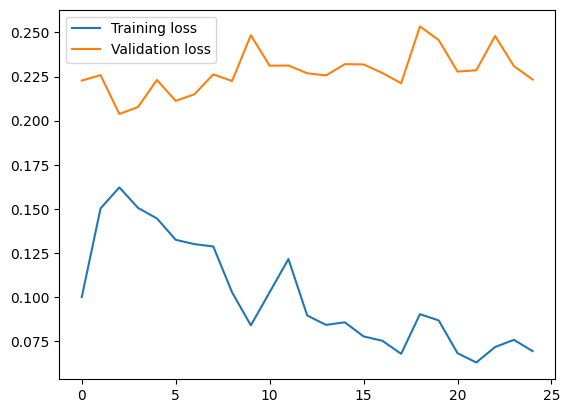

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.legend()
plt.show()

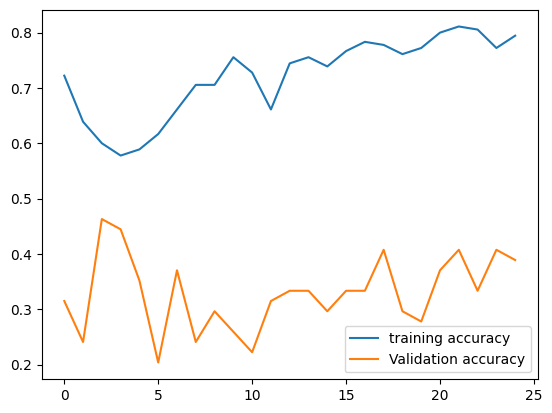

In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy')

plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
#sets to 1 for the labels wihich are not predicted
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
y_true = [label_dict[label] for label in labels]
y_pred = np.argmax(model.predict(X), axis=-1)
accuracy = accuracy_score(y_pred, y_true)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 score: {f1:.2%}")


9/9 [==============================] - 2s 124ms/step
Accuracy: 65.89%
Precision: 76.86%
Recall: 65.89%
F1 score: 64.75%


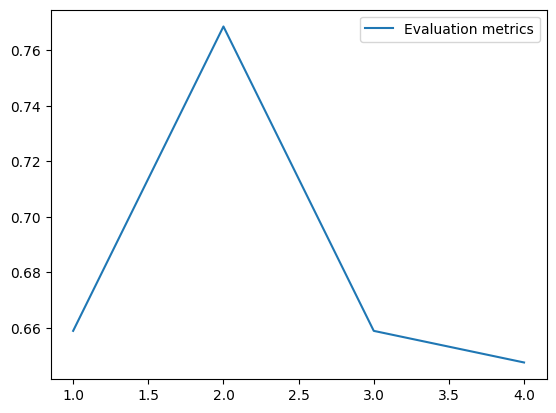

In [ ]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3, 4], [accuracy, precision, recall, f1], label='Evaluation metrics')
plt.legend()
plt.show()


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels from one-hot encoded vectors to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert the true labels from one-hot encoded vectors to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average="weighted")
recall = recall_score(y_true_labels, y_pred_labels, average="weighted")
f1 = f1_score(y_true_labels, y_pred_labels, average="weighted")

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

1/1 [==============================] - 2s 2s/step
Accuracy: 20.83%
Precision: 50.79%
Recall: 20.83%
F1 score: 21.45%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
